In [2]:
# Recall : autoencoder is trained to Minimize Reconstruction Error
# You will train an autoencoder on the normal rhythms only,
# Then use it to reconstruct all the data

# 載入心電圖 : Load ECG data (Electrocardiograms)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses
from keras.models import Model
import tensorflow as tf

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
print(dataframe.head())

# 心電圖csv最後一欄是label : 0 = 不正常 abnormal rhythm, 1 = 正常 normal rhythm
labels = raw_data[:, -1]

# 其他欄位是心電特徵
data = raw_data[:, 0:-1]

# Part I . Data PreProcessing
# 分割數據成訓練集，測試集
X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, test_size = 0.2, random_state = 21
)

        0         1         2         3         4         5         6     
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408  \
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134   
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621  \
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.2577

In [3]:
MNScaler = MinMaxScaler()
X_train = MNScaler.fit_transform(X_train) # 先學習train的歸一化特徵(Min,Max)，再對train進行歸一化
X_test = MNScaler.transform(X_test) # 因為已經學習train的歸一化特徵，所以用同樣(模型)的標準對test歸一化



In [4]:
# 在訓練AutoEncoder時只使用正常訊號 -> 將label = 1 -> True的資料取出
Y_train = Y_train.astype(bool) # 標籤形成布林值矩陣
Y_test = Y_test.astype(bool)
print(Y_train)

normal_X_train = X_train[Y_train] # 布林值為True的值會被提出來->正常心電圖數據(np.array)
normal_X_test = X_test[Y_test]

anomalous_X_train = X_train[~Y_train]
anomalous_X_test = X_test[~Y_test]
print(X_train.shape)

[ True  True  True ...  True  True  True]
(3998, 140)


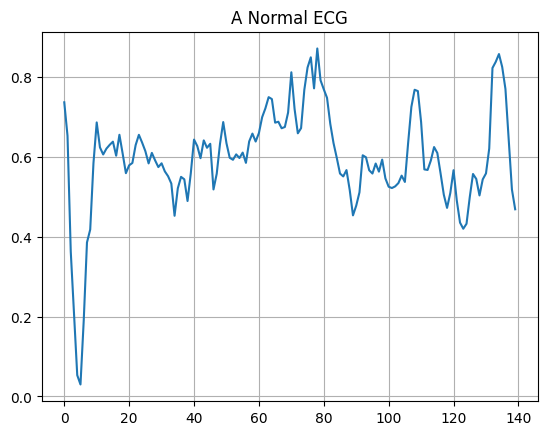

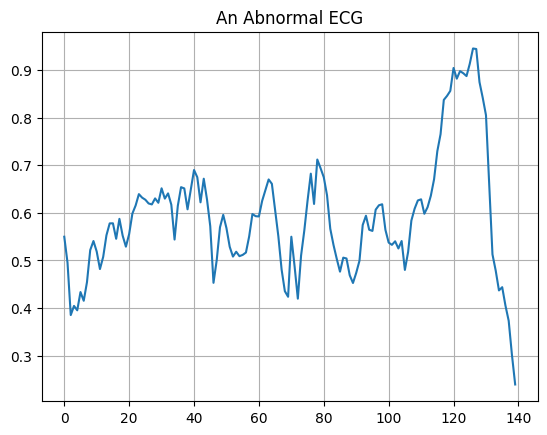

In [5]:
# 劃出正常的心電圖 Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_X_train[0])
plt.title("A Normal ECG")
plt.show()

# 劃出異常的心電圖 Plot an abnormal ECG
plt.grid()
plt.plot(np.arange(140), anomalous_X_train[0])
plt.title("An Abnormal ECG")
plt.show()

In [ ]:
def get_model(latent_dim):
    # Encoder
    input = layers.Input(shape = (140,), name = 'ECG input')
    e = layers.Dense(32, activation = 'relu',name = 'Dense1')(input)
    e = layers.Dense(16, activation = 'relu',name = 'Dense2')(e)
    e = layers.Dense(latent_dim, activation = 'relu',name = 'BottleNeck')(e)
    # Decoder
    d = layers.Dense(16, activation = 'relu',name = 'Dense3')(e)
    d = layers.Dense(32, activation = 'relu',name = 'Dense4')(d)
    output = layers.Dense(140, activation = 'sigmoid',name = 'output')(d) # Output最終判斷是否為正常 0~1 -> 分類 ； 但是，只要是歸一化(0~1)的數據，也可以使用sigmoid function去做回歸 ； 但是 linear是通常做為回歸任務(返回任何數字)的選擇
    autoencoder_model = Model(inputs = [input], outputs = [output])
    return autoencoder_model

n_bottle_neck = 8
autoencoder = get_model(8)
autoencoder.compile(optimizer='adam', loss='mae')

Epoch 1/100
11/11 [==============================] - 2s 17ms/step - loss: 0.1299 - val_loss: 0.1349
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1226 - val_loss: 0.1251
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1097 - val_loss: 0.1121
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0935 - val_loss: 0.0994
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0779 - val_loss: 0.0888
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0651 - val_loss: 0.0822
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0558 - val_loss: 0.0790
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0507 - val_loss: 0.0777
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0485 - val_loss: 0.0766
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0475 - val_loss: 0.0756
Epoch 11

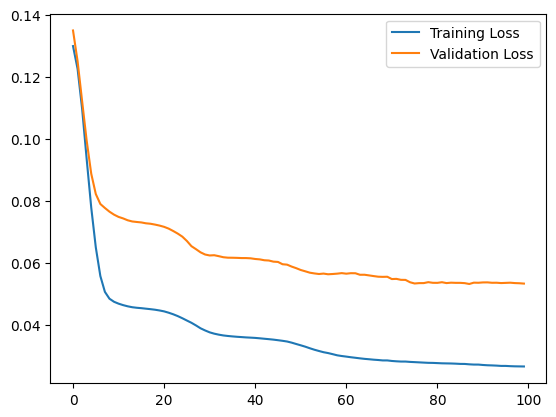

In [7]:
# 注意 : 此時 AutoEncoder Model只訓練正常資料(ECGs)，訓練如何還原正常資料時的特徵(normal_X_train)，但在評估這個模型時是使用"全部"的資料(X_test)

history = autoencoder.fit(normal_X_train, normal_X_train, epochs= 100, batch_size= 216, validation_data= (X_test,X_test), shuffle = True)# shuffle : 每個 epoch 開始時，將訓練數據打亂（或者說 "洗牌"）
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

18/18 [==============================] - 0s 3ms/step


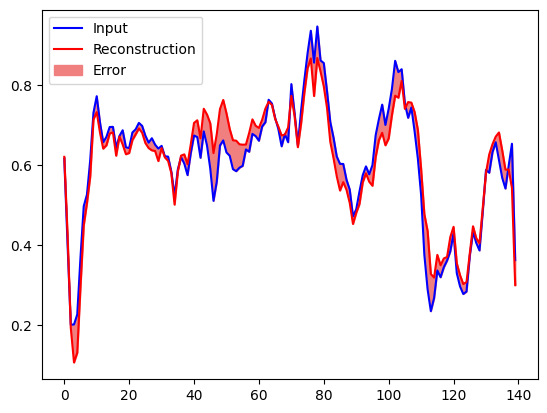

In [8]:
# 訓練完後，使用正常的測試data來驗證還原程度
X_test_hat = autoencoder.predict(normal_X_test)
plt.plot(normal_X_test[0], 'b')
plt.plot(X_test_hat[0], 'r')
plt.fill_between(np.arange(140), X_test_hat[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

14/14 [==============================] - 0s 4ms/step


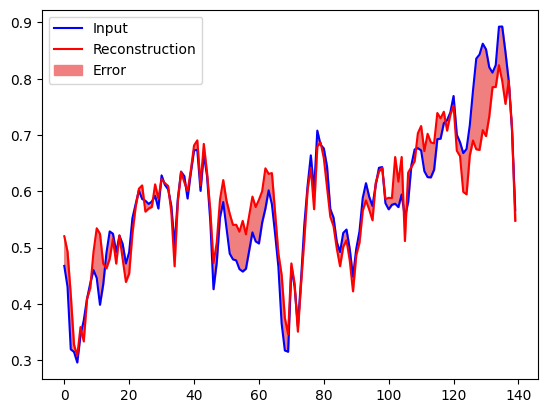

In [9]:
# 訓練完後，使用不正常的測試data來驗證還原程度
anomalous_X_test_hat = autoencoder.predict(anomalous_X_test)
plt.plot(anomalous_X_test[0], 'b')
plt.plot(anomalous_X_test_hat[0], 'r')
plt.fill_between(np.arange(140), anomalous_X_test_hat[0], anomalous_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 3ms/step
(2359,)


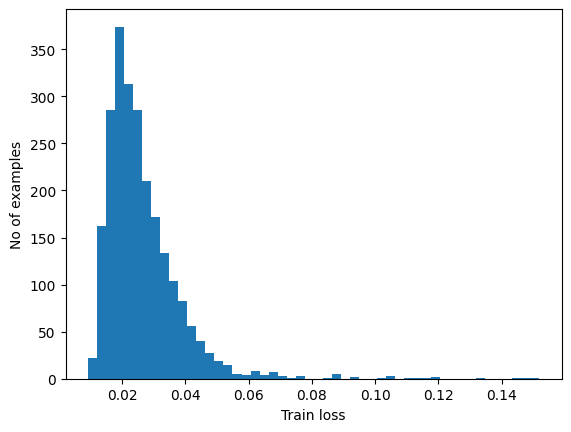

In [10]:
# Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.
# 異常基準 : 重建的loss大於一定的threshold值 -> 異常
# 先劃出Autoencoder 在訓練及重建時的error

reconstructions_train = autoencoder.predict(normal_X_train)
# 使用MAE (Mean Average Error) 計算 每個重建資料對原生訓練資料的重建誤差
train_loss = tf.keras.losses.mae(reconstructions_train, normal_X_train)
print(train_loss.shape)

# 直方圖統計 每個重建error各佔了幾筆
plt.hist(train_loss[:],bins = 50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [11]:
# 選擇的Threshold = 所有重建loss的平均值上一個所有重建loss的標準差
# Choose a threshold value that is one standard deviations above the mean.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03934491025322348


14/14 [==============================] - 0s 3ms/step


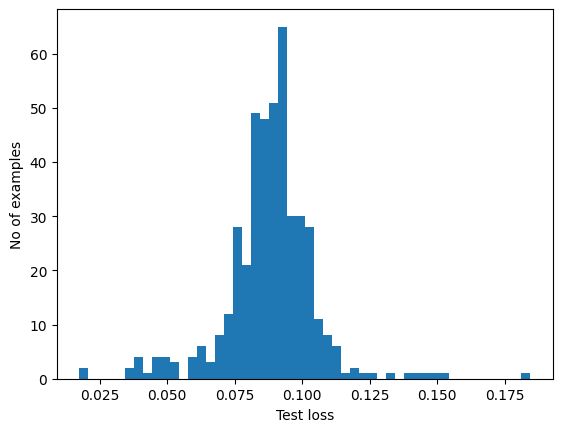

In [12]:
# 查看Autoencoder對測試集的異常資料之重建誤差
# 藉由調整Threshold,可以調整分類的精確度(Precision) 以及 召回率 (recall)
# 可以看出每筆資料的重建誤差來到0.1

reconstructions_test_anomalous = autoencoder.predict(anomalous_X_test)
test_loss = tf.keras.losses.mae(reconstructions_test_anomalous,anomalous_X_test)

plt.hist(test_loss[:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [13]:
# 如果重建error > threshold : 則 ECG 心電圖是異常的 
# 製作分類氣

def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold) # 以數學表示這個loss是否小於threshold(布林值)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))   # TP / 總樣本數量
  print("Precision = {}".format(precision_score(labels, predictions))) # TP / TP + FP : 精確率高表示假陽性率低
  print("Recall = {}".format(recall_score(labels, predictions))) # TP / TP + FN : 召回率高表示假陰性率低

preds = predict(autoencoder, X_test, threshold) # 將全部的測試資料進行還原，查看全部資料的還原Error是否低於一定的Thoreshold (是 -> 1 = 正常)
print_stats(preds, Y_test) # 將判斷完的全部資料布林值(數字形式)，與全部原生標籤做比對，查看混淆矩陣

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step
Accuracy = 0.939
Precision = 0.9901768172888016
Recall = 0.9


In [14]:
normal_X_train.shape

(2359, 140)

In [15]:
anomalous_X_test.shape

(440, 140)